In [50]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [51]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [52]:
from __future__ import print_function
# from numpy import *
# from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
from salishsea_tools import visualisations as vis
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
import datetime as dt

%matplotlib inline

In [53]:
def make_nclen(start,end,ftype, sdir):
    date_ar = []
    sens_ar = []
    doy_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        dddd = tdate.format('DDDD')
        nc_sens = sdir + '/SKOG_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        tnc_sens = glob.glob(nc_sens)
        sens_ar.append(tnc_sens[0])
        date_ar.append(ddmmmyy)
        doy_ar.append(dddd)
    return date_ar, sens_ar, doy_ar

In [54]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]
    size_2 = size_box[2]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1,size_2)
    OmAr = OmegaA.reshape(size_0,size_1,size_2)
    pco2r = pco2.reshape(size_0,size_1,size_2)
    
    return pHr, OmAr, pco2r

In [55]:
start = '2015-01-01'
end = '2015-12-30'

st = dt.datetime(2015,1,1)
en = dt.datetime(2015,12,30)

y_st = st.timetuple().tm_yday
print(y_st)
y_en = en.timetuple().tm_yday
print(y_en)
ts_BR = np.arange(y_st,y_en+1,1)

sdir_preind = '/data/tjarniko/results/BASERUN_EXP/PI_3rd_2015/ncs/'
sdir_br = '/data/tjarniko/results/BASERUN_EXP/BR_2nd_2015/ncs/'

dates_preind_carp, files_preind_carp, doy_preind = make_nclen(start,end,'carp', sdir_preind)
dates_br_carp, files_br_carp, doy_br = make_nclen(start,end,'carp', sdir_br)
dates_preind_grid, files_preind_grid, doy_preind = make_nclen(start,end,'grid_T', sdir_preind)
dates_br_grid, files_br_grid, doy_br = make_nclen(start,end,'grid_T', sdir_br)

1
364


In [56]:
day = 90
test_br_grid = nc.Dataset(files_br_grid[day])
test_br_carp = nc.Dataset(files_br_carp[day])
test_preind_grid = nc.Dataset(files_preind_grid[day])
test_preind_carp = nc.Dataset(files_preind_carp[day])

depth_t = test_br_grid['deptht'][:]

a = 40
b = 898
c = 398
d = depth_t
depth_broad = np.empty((a, b, c))
for b in range(0,898):
    for c in range(0,398):
        depth_broad[:,b,c] = depth_t

In [57]:
DIC_br = test_br_carp['dissolved_inorganic_carbon'][0,:,:,:]
TA_br = test_br_carp['total_alkalinity'][0,:,:,:]
SAL_br = test_br_grid['vosaline'][0,:,:,:]
TEMP_br = test_br_grid['votemper'][0,:,:,:]

DIC_preind = test_preind_carp['dissolved_inorganic_carbon'][0,:,:,:]
TA_preind = test_preind_carp['total_alkalinity'][0,:,:,:]
SAL_preind = test_preind_grid['vosaline'][0,:,:,:]
TEMP_preind = test_preind_grid['votemper'][0,:,:,:]

pHr_preind, OmAr_preind, pco2r_preind = oned_moxy(SAL_preind, TEMP_preind, DIC_preind, TA_preind, 1, depth_broad)
pHr_br, OmAr_br, pco2r_br = oned_moxy(SAL_br, TEMP_br, DIC_br, TA_br, 1, depth_broad)

bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

In [58]:
zlevels = (test_br_grid['deptht'])

In [59]:
def contour_thalweg(
    axes, var, bathy, mesh_mask, sat_hor, clevels=None,
    mesh_mask_depth_var='gdept_0', cmap='hsv', land_colour='burlywood',
    xcoord_distance=True,
    thalweg_file='/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt',
    cbar_args=None,
    mesh_args=None,
    method='contourf'
):

    thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
    depth = mesh_mask.variables[mesh_mask_depth_var][:]
    dep_thal, distance, var_thal = load_thalweg(
        depth[0, ...], var, bathy['nav_lon'][:], bathy['nav_lat'][:],
        thalweg_pts)
    if xcoord_distance:
        xx_thal = distance
        axes.set_xlabel('Distance along thalweg [km]')
    else:
        xx_thal, _ = np.meshgrid(np.arange(var_thal.shape[-1]), dep_thal[:, 0])
        axes.set_xlabel('Thalweg index')
    # Determine contour levels
    clevels_default = {
        'salinity': [
            26, 27, 28, 29, 30, 30.2, 30.4, 30.6, 30.8, 31, 32, 33, 34
        ],
        'temperature': [
            6.9, 7, 7.5, 8, 8.5, 9, 9.8, 9.9, 10.3, 10.5, 11, 11.5, 12,
            13, 14, 15, 16, 17, 18, 19
        ]
    }
    if isinstance(clevels, str):
        try:
            clevels = clevels_default[clevels]
        except KeyError:
            raise KeyError('no default clevels defined for {}'.format(clevels))
    # Prepare for plotting by filling in grid points just above bathymetry
    var_plot = _fill_in_bathy(var_thal, mesh_mask, thalweg_pts)

    if method == 'pcolormesh':
        if mesh_args is None:
            mesh = axes.pcolormesh(xx_thal, dep_thal, var_plot, cmap=cmap)

        else:
            mesh = axes.pcolormesh(xx_thal, dep_thal, var_plot, cmap=cmap, **mesh_args)

        axes.set_xlim((np.min(xx_thal),np.max(xx_thal)))

           
    else:
        if mesh_args is None:
            mesh = axes.contourf(xx_thal, dep_thal, var_plot, clevels, cmap=cmap,
                        extend='both')
            print(np.shape(xx_thal))
            print(np.shape(dep_thal))
            axes.plot( xx_thal[20,:],sat_hor[:], '-k')
            #axes.plot([-1, 1], [-1, 1], '-k')

        else:
            mesh = axes.contourf(xx_thal, dep_thal, var_plot, clevels, cmap=cmap,
                        extend='both', **mesh_args)

    _add_bathy_patch(
        xx_thal, bathy['Bathymetry'][:], thalweg_pts, axes, color=land_colour)
    if cbar_args is None:
        cbar = plt.colorbar(mesh, ax=axes)
    else:
        cbar = plt.colorbar(mesh, ax=axes, **cbar_args)

    axes.invert_yaxis()
    axes.set_ylabel('Depth [m]')
    return cbar


def _add_bathy_patch(xcoord, bathy, thalweg_pts, ax, color, zmin=450):

    # Look up bottom bathymetry along thalweg
    thalweg_bottom = bathy[thalweg_pts[:, 0], thalweg_pts[:, 1]]
    # Construct bathy polygon
    poly = np.zeros((thalweg_bottom.shape[0]+2, 2))
    poly[0, :] = 0, zmin
    poly[1:-1, 0] = xcoord[0, :]
    poly[1:-1:, 1] = thalweg_bottom
    poly[-1, :] = xcoord[0, -1], zmin
    ax.add_patch(patches.Polygon(poly, facecolor=color, edgecolor=color))

def load_thalweg(depths, var, lons, lats, thalweg_pts):


    lons_thal = lons[thalweg_pts[:, 0], thalweg_pts[:, 1]]
    lats_thal = lats[thalweg_pts[:, 0], thalweg_pts[:, 1]]
    var_thal = var[:, thalweg_pts[:, 0], thalweg_pts[:, 1]]

    xx_thal = geo_tools.distance_along_curve(lons_thal, lats_thal)
    xx_thal = xx_thal + np.zeros(var_thal.shape)

    if depths.ndim > 1:
        dep_thal = depths[:, thalweg_pts[:, 0], thalweg_pts[:, 1]]
    else:
        _, dep_thal = np.meshgrid(xx_thal[0, :], depths)
    return dep_thal, xx_thal, var_thal

def _fill_in_bathy(variable, mesh_mask, thalweg_pts):

    mbathy = mesh_mask.variables['mbathy'][0, :, :]
    newvar = np.copy(variable)

    mbathy = mbathy[thalweg_pts[:, 0], thalweg_pts[:, 1]]
    for i, level in enumerate(mbathy):
        newvar[level, i] = variable[level-1, i]
    return newvar

def contour_layer_grid(axes,data,mask,clevels=10,lat=None,lon=None,cmap=None,var_name=None,
                       land_colour='burlywood',is_depth_avg=False,is_pcolmesh=False,title='',cbar_args=None):

    mdata = np.ma.masked_where(mask==0,data)

    viz_tools.set_aspect(axes)

    if cmap == None:
        cbMIN, cbMAX, cmap = visualisations.retrieve_cmap(var_name,is_depth_avg)
        cmap = plt.get_cmap(cmocean.cm.algae)

    if is_pcolmesh:
        mesh = axes.pcolormesh(mdata, cmap=cmap)
    else:
        mesh= axes.contourf(mdata,clevels,cmap=cmap)

    axes.set_xlabel('X index')
    axes.set_ylabel('Y index')
    axes.set_title(title)

    axes.set_axis_bgcolor(land_colour)


    if cbar_args is None:
        cbar = plt.colorbar(mesh, ax=axes)
    else:
        cbar = plt.colorbar(mesh, ax=axes, **cbar_args)

    return cbar

In [60]:
thalweg_file='/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
oma_depths = np.zeros([1533])
T_OmAr = OmAr_preind[:,thalweg_pts[:, 0], thalweg_pts[:, 1]]


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

print(np.shape(T_OmAr))
for i in range(0,1533):
    t_slice = T_OmAr[:,i]
    val, idx = find_nearest(t_slice,1)
    oma_depths[i] = zlevels[idx]
    
#print(oma_depths)


(40, 1533)


(40, 1533)
(40, 1533)


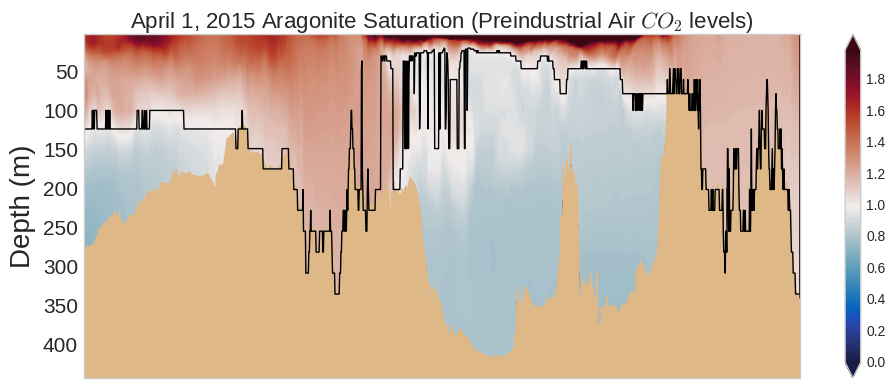

In [61]:
t_cmap = cm.cm.balance
t_vmin_OmA = 0
t_vmax_OmA = 2
stepsize = 0.01
fig, ax1 = plt.subplots(1,1,figsize=(10,4))
cbar1 = contour_thalweg(ax1, OmAr_preind, bathy, mesh, oma_depths, np.arange(t_vmin_OmA, t_vmax_OmA, stepsize), cmap = t_cmap)
ax1.set_title('April 1, 2015 Aragonite Saturation (Preindustrial Air $CO_2$ levels)', fontsize = 16)
ax1.set_ylabel('Depth (m)', fontsize = 20)
#cbar1.set_label('$\Omega_A$', fontsize = 20)
ax1.set_xlabel('', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xticklabels([])


fig.tight_layout()

## Scipy attempts


In [62]:
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = sp.interpolate.interp1d(x, y)

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

AttributeError: module 'scipy.interpolate' has no attribute 'interp1d'